##Importing utilities

In [1]:
!pip install roboflow
from roboflow import Roboflow
import matplotlib.pyplot as plt
import matplotlib.image as read
import torch
from torchvision import transforms
from PIL import Image
import cv2
import numpy as np
import json
from google.colab.patches import cv2_imshow
import math

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.2/72.2 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 7.4 MB/s eta 0:00:00
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.1.1
    Uninstalling pyparsing-3.1.1:
      Successfully uninstalled pyparsing-3.1.1
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.8.1.78
    Uninstalling opencv-python-headless-4.8.1.78:
      Successfully uninstalled opencv-python-headless-4.8.1.78
  Attempting uninstall: idna
    Found existi

##Import the object detection model trained on roboflow

In [2]:
rf = Roboflow(api_key="AcDWtmJ25mTDmedADOsr")
project = rf.workspace().project("color_strip-identifyer")
model = project.version(8).model

loading Roboflow workspace...
loading Roboflow project...


In [3]:
def drawImage(img,title="Image"):
    plt.imshow(img,cmap="gray")
    plt.axis("off")
    plt.title(title)
    plt.show()

In [4]:
def distance(predT, predStrip):
  xT = predT['x']
  yT = predT['y']

  xStrip = predStrip['x']
  yStrip = predStrip['y']

  return math.sqrt((xT - xStrip)**2 + (yT - yStrip)**2)

In [5]:
def process(pred, gray_image):
  roi_x = int(pred['x'] - pred['width'] / 2);
  roi_y = int(pred['y'] - pred['height'] / 2);
  roi_width = int(pred['width'])
  roi_height = int(pred['height'])
  roi = gray_image[roi_y:roi_y+roi_height, roi_x:roi_x+roi_width]
  return roi

Crop out C & T lines

In [24]:
def crop(path):
  image = cv2.imread(path)
  prediction = model.predict(path, confidence=10, overlap=30).json()
  print(prediction)
  gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

  T = []
  color_strips = []
  C_strip = {}
  T_strip = {}

  # color = (b, g, r)
  # segregate T and color strips
  for pred in prediction['predictions']:
    if pred['class'] == 'T':
      T.append(pred)
      image = cv2.circle(image, (int(pred['x']), int(pred['y'])), radius=5, color=(0, 0, 255), thickness=-1) # red dot
    else:
      color_strips.append(pred)

  if len(color_strips) != 2 or len(T) != 1:
    print(len(color_strips), len(T))
    raise Exception("An error occured, model did not detect correctly")

  # Check the distance with character T
  if distance(T[0], color_strips[0]) < distance(T[0], color_strips[1]):
    T_strip = color_strips[0]
    C_strip = color_strips[1]
  else:
    T_strip = color_strips[1]
    C_strip = color_strips[0]

  image = cv2.circle(image, (int(C_strip['x']), int(C_strip['y'])), radius=5, color=(0, 255, 0), thickness=-1) # green dot
  image = cv2.circle(image, (int(T_strip['x']), int(T_strip['y'])), radius=5, color=(255, 0, 0), thickness=-1) # blue dot

  cv2_imshow(image)


  result = [process(C_strip, gray_image), process(T_strip, gray_image)]
  return result # first one is C_strip, second is T_strip

##Resize the image to make all images of same size

In [8]:
def resize(img):
    new_width = 128
    new_height = 50

    # Resize the image to the new dimensions
    resized_image = cv2.resize(img, (new_width, new_height))
    return resized_image

##Measure intensity of C & T lines by taking mean of pixel intensities.

--threshold is used to eliminate the background

In [9]:
def m_intensity(img, threshold):

    # Create a mask for pixels above the threshold
    mask = (img > threshold).astype(np.uint8)

    # Calculate the mean intensity for the masked pixels
    mean_intensity = cv2.mean(img, mask=mask)

    # Extract the mean intensity value (since cv2.mean returns a tuple)
    mean_intensity_value = mean_intensity[0]
    return mean_intensity_value

##Function inputs path of image and appends the T/C ratio to an array

In [30]:
def work(path, T_C_ratio):
    image_tensors = crop(path)

    resized_C= resize(image_tensors[0])
    resized_T = resize(image_tensors[1])

    negative_image_C = cv2.bitwise_not(resized_C)
    negative_image_T = cv2.bitwise_not(resized_T)

    filtered_image_C = cv2.medianBlur(negative_image_C, 63)
    filtered_image_T = cv2.medianBlur(negative_image_T, 63)

    mean_intensity_C = m_intensity(filtered_image_C, 50)
    mean_intensity_T = m_intensity(filtered_image_T, 50)

    T_C_ratio.append(mean_intensity_T / mean_intensity_C)

In [40]:
T_C_ratio=[]
paths =['/content/28 IU per ml 696.jpg',
       '/content/33 IU per ml 600.jpg',
       '/content/40 IUml 700.jpg',
       '/content/45 IU per ml 600.jpg',
       '/content/50 IU per ml 435.jpg'
       ]

{'predictions': [{'x': 542.0, 'y': 1236.0, 'width': 124.0, 'height': 50.0, 'confidence': 0.7487533092498779, 'class': 'color_strip', 'class_id': 1, 'image_path': '/content/28 IU per ml 696.jpg', 'prediction_type': 'ObjectDetectionModel'}, {'x': 534.0, 'y': 1482.0, 'width': 124.0, 'height': 64.0, 'confidence': 0.6935043334960938, 'class': 'color_strip', 'class_id': 1, 'image_path': '/content/28 IU per ml 696.jpg', 'prediction_type': 'ObjectDetectionModel'}, {'x': 320.0, 'y': 1470.5, 'width': 90.0, 'height': 165.0, 'confidence': 0.5520251393318176, 'class': 'T', 'class_id': 0, 'image_path': '/content/28 IU per ml 696.jpg', 'prediction_type': 'ObjectDetectionModel'}], 'image': {'width': '1080', 'height': '1920'}}


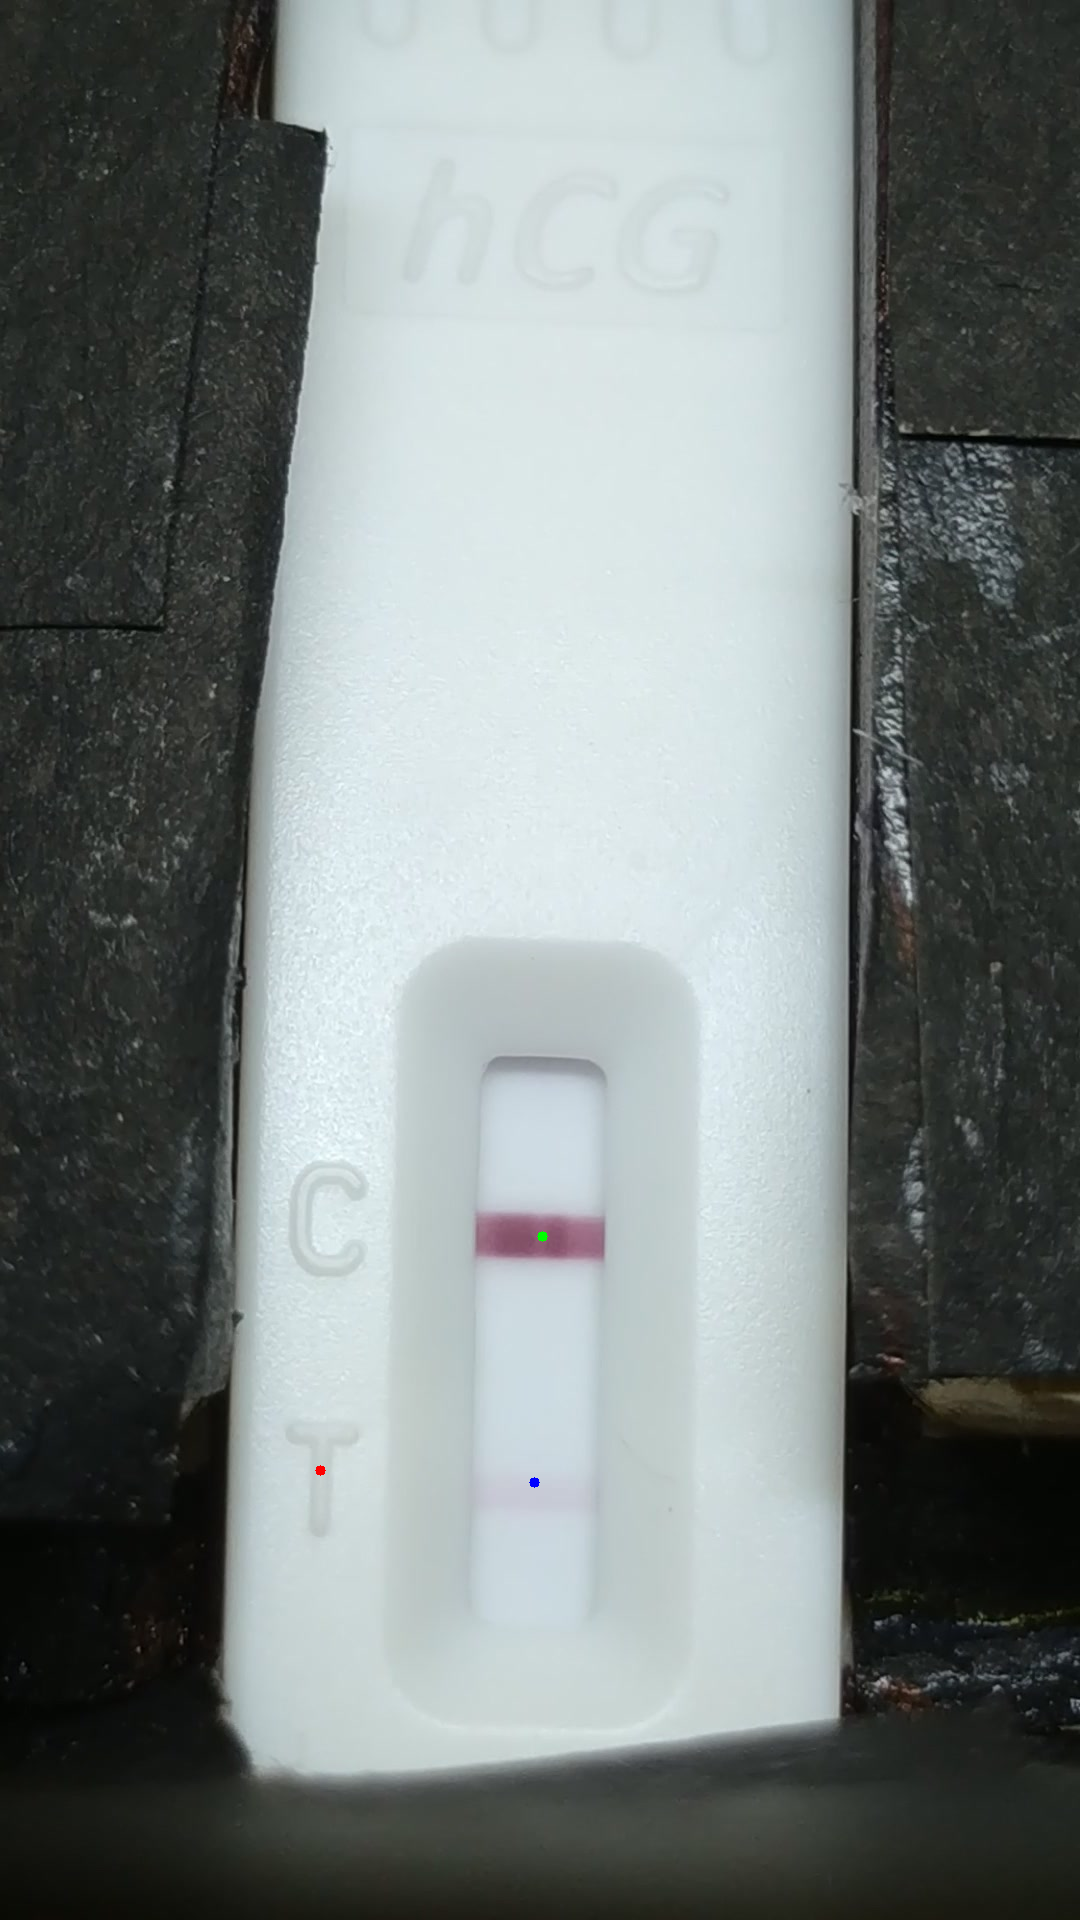

In [41]:
work(paths[0], T_C_ratio)

{'predictions': [{'x': 461.5, 'y': 1244.5, 'width': 139.0, 'height': 59.0, 'confidence': 0.8459720611572266, 'class': 'color_strip', 'class_id': 1, 'image_path': '/content/33 IU per ml 600.jpg', 'prediction_type': 'ObjectDetectionModel'}, {'x': 453.5, 'y': 1508.0, 'width': 133.0, 'height': 64.0, 'confidence': 0.7739292979240417, 'class': 'color_strip', 'class_id': 1, 'image_path': '/content/33 IU per ml 600.jpg', 'prediction_type': 'ObjectDetectionModel'}, {'x': 219.0, 'y': 1494.5, 'width': 92.0, 'height': 173.0, 'confidence': 0.555609941482544, 'class': 'T', 'class_id': 0, 'image_path': '/content/33 IU per ml 600.jpg', 'prediction_type': 'ObjectDetectionModel'}], 'image': {'width': '1080', 'height': '1920'}}


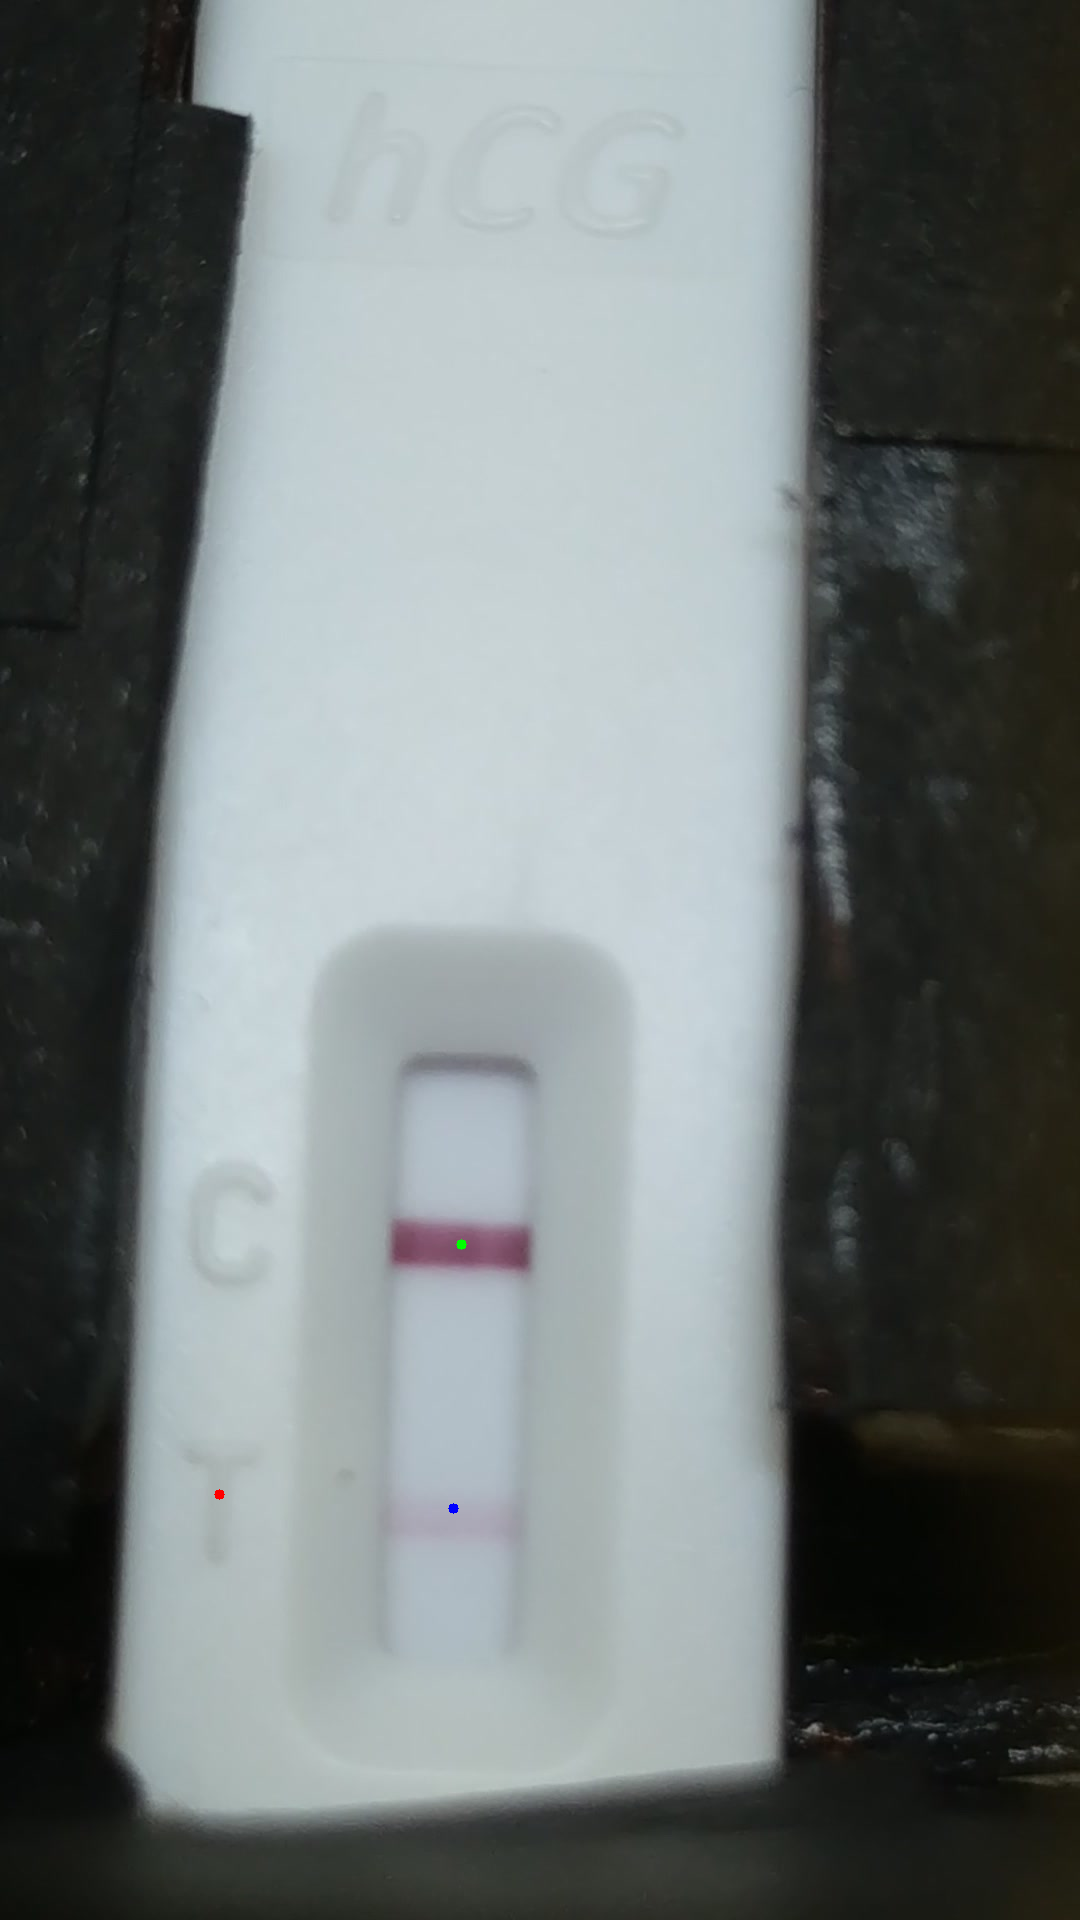

In [42]:
work(paths[1], T_C_ratio)

{'predictions': [{'x': 461.0, 'y': 648.5, 'width': 130.0, 'height': 57.0, 'confidence': 0.8538439869880676, 'class': 'color_strip', 'class_id': 1, 'image_path': '/content/40 IU\uf022ml 700.jpg', 'prediction_type': 'ObjectDetectionModel'}, {'x': 465.5, 'y': 904.5, 'width': 131.0, 'height': 55.0, 'confidence': 0.8265836238861084, 'class': 'color_strip', 'class_id': 1, 'image_path': '/content/40 IU\uf022ml 700.jpg', 'prediction_type': 'ObjectDetectionModel'}, {'x': 243.5, 'y': 913.5, 'width': 87.0, 'height': 167.0, 'confidence': 0.579839825630188, 'class': 'T', 'class_id': 0, 'image_path': '/content/40 IU\uf022ml 700.jpg', 'prediction_type': 'ObjectDetectionModel'}], 'image': {'width': '1080', 'height': '1920'}}


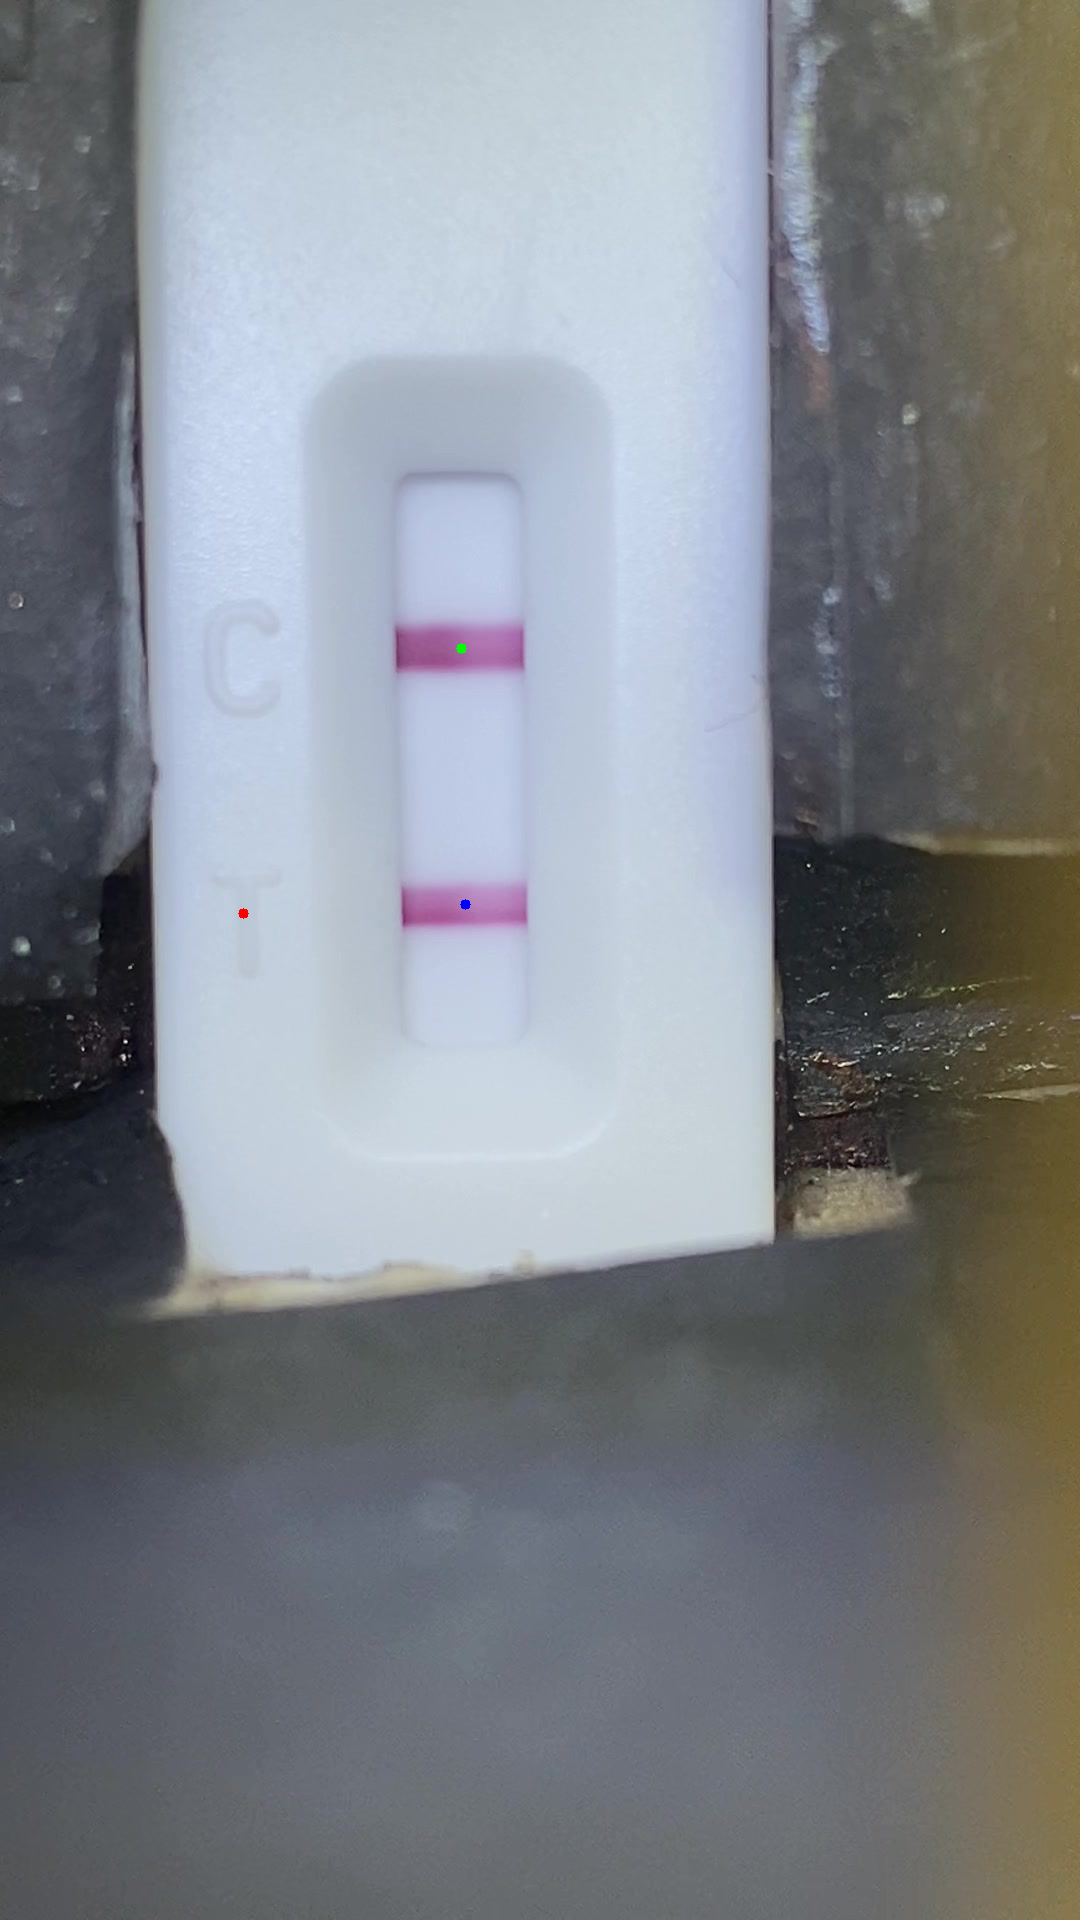

In [43]:
work(paths[2], T_C_ratio)

{'predictions': [{'x': 618.0, 'y': 1307.5, 'width': 128.0, 'height': 57.0, 'confidence': 0.8311471939086914, 'class': 'color_strip', 'class_id': 1, 'image_path': '/content/45 IU per ml 600.jpg', 'prediction_type': 'ObjectDetectionModel'}, {'x': 614.5, 'y': 1566.5, 'width': 131.0, 'height': 55.0, 'confidence': 0.8204793930053711, 'class': 'color_strip', 'class_id': 1, 'image_path': '/content/45 IU per ml 600.jpg', 'prediction_type': 'ObjectDetectionModel'}, {'x': 387.0, 'y': 1557.5, 'width': 92.0, 'height': 185.0, 'confidence': 0.5383585095405579, 'class': 'T', 'class_id': 0, 'image_path': '/content/45 IU per ml 600.jpg', 'prediction_type': 'ObjectDetectionModel'}], 'image': {'width': '1080', 'height': '1920'}}


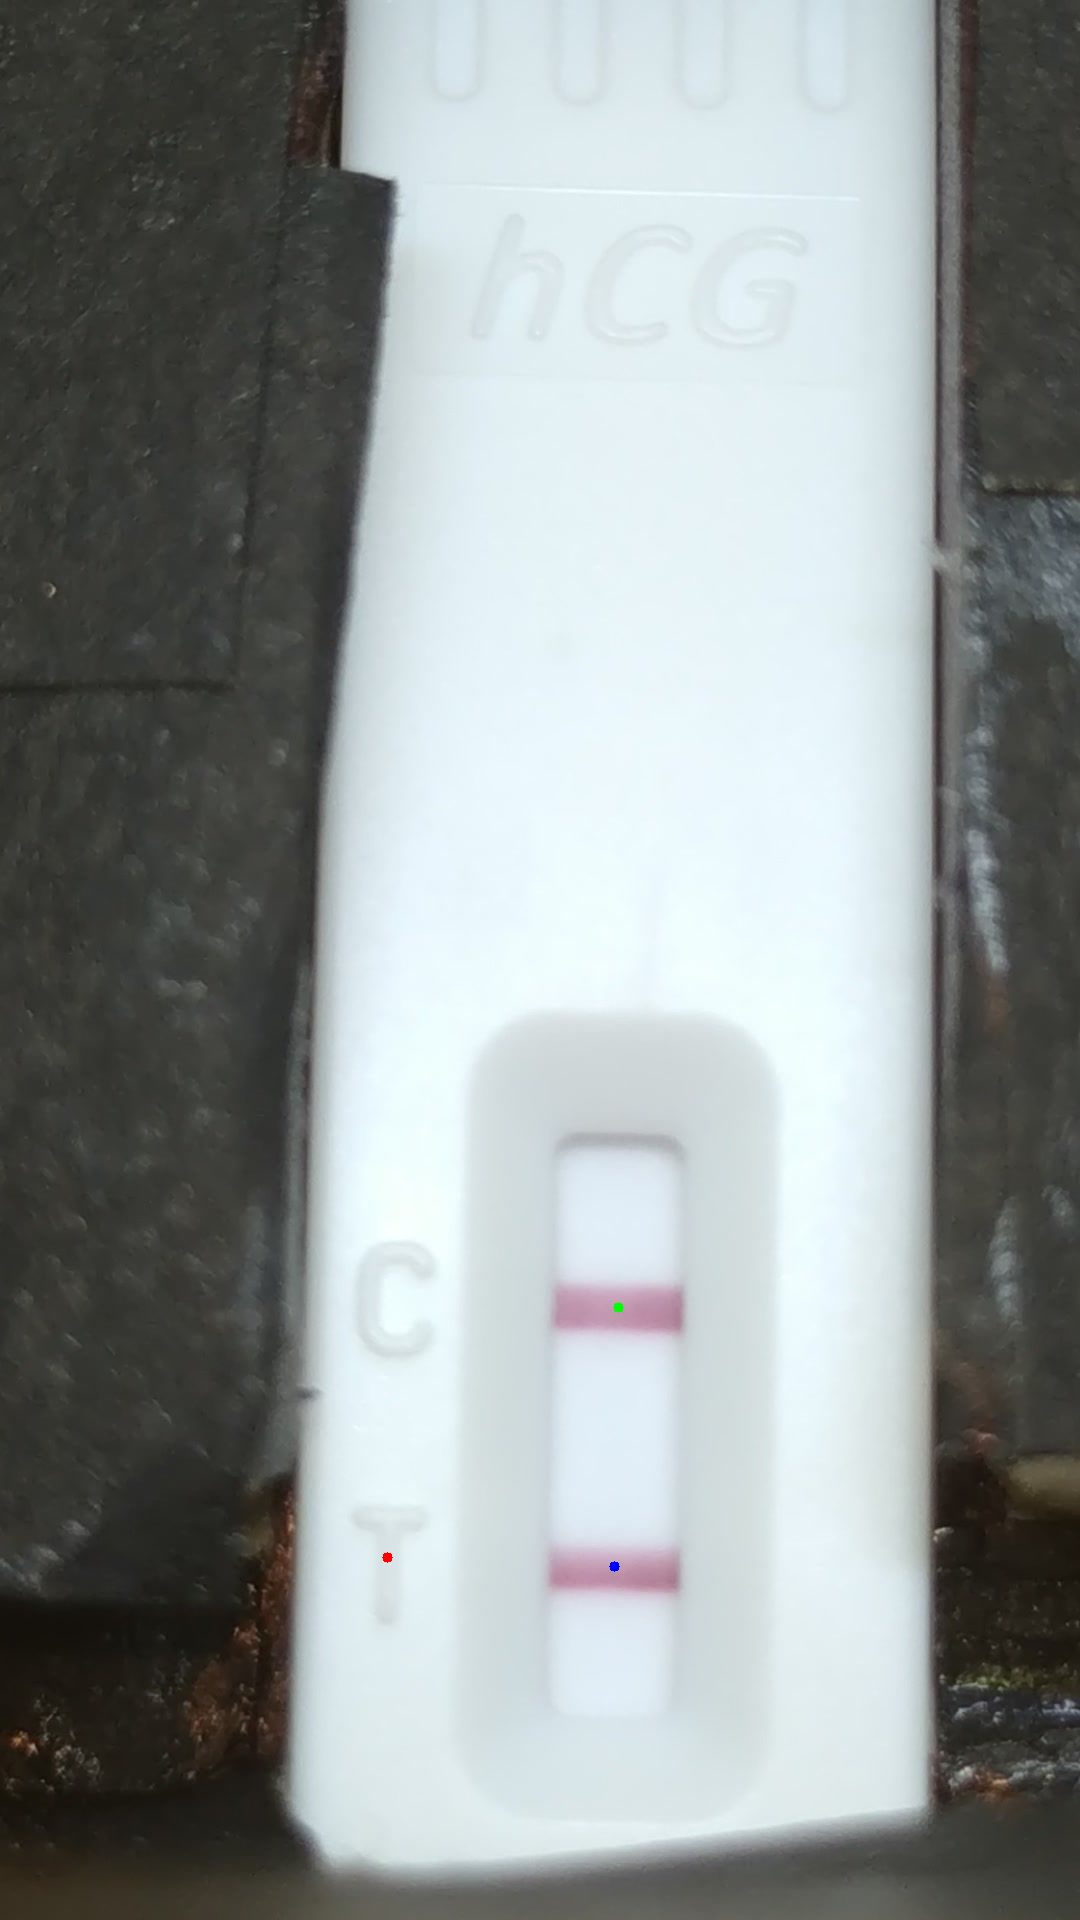

In [44]:
work(paths[3], T_C_ratio)

{'predictions': [{'x': 564.5, 'y': 1245.5, 'width': 135.0, 'height': 57.0, 'confidence': 0.8408246040344238, 'class': 'color_strip', 'class_id': 1, 'image_path': '/content/50 IU per ml 435.jpg', 'prediction_type': 'ObjectDetectionModel'}, {'x': 556.5, 'y': 1508.0, 'width': 127.0, 'height': 56.0, 'confidence': 0.8377276062965393, 'class': 'color_strip', 'class_id': 1, 'image_path': '/content/50 IU per ml 435.jpg', 'prediction_type': 'ObjectDetectionModel'}, {'x': 328.5, 'y': 1502.0, 'width': 89.0, 'height': 152.0, 'confidence': 0.5501750111579895, 'class': 'T', 'class_id': 0, 'image_path': '/content/50 IU per ml 435.jpg', 'prediction_type': 'ObjectDetectionModel'}], 'image': {'width': '1080', 'height': '1920'}}


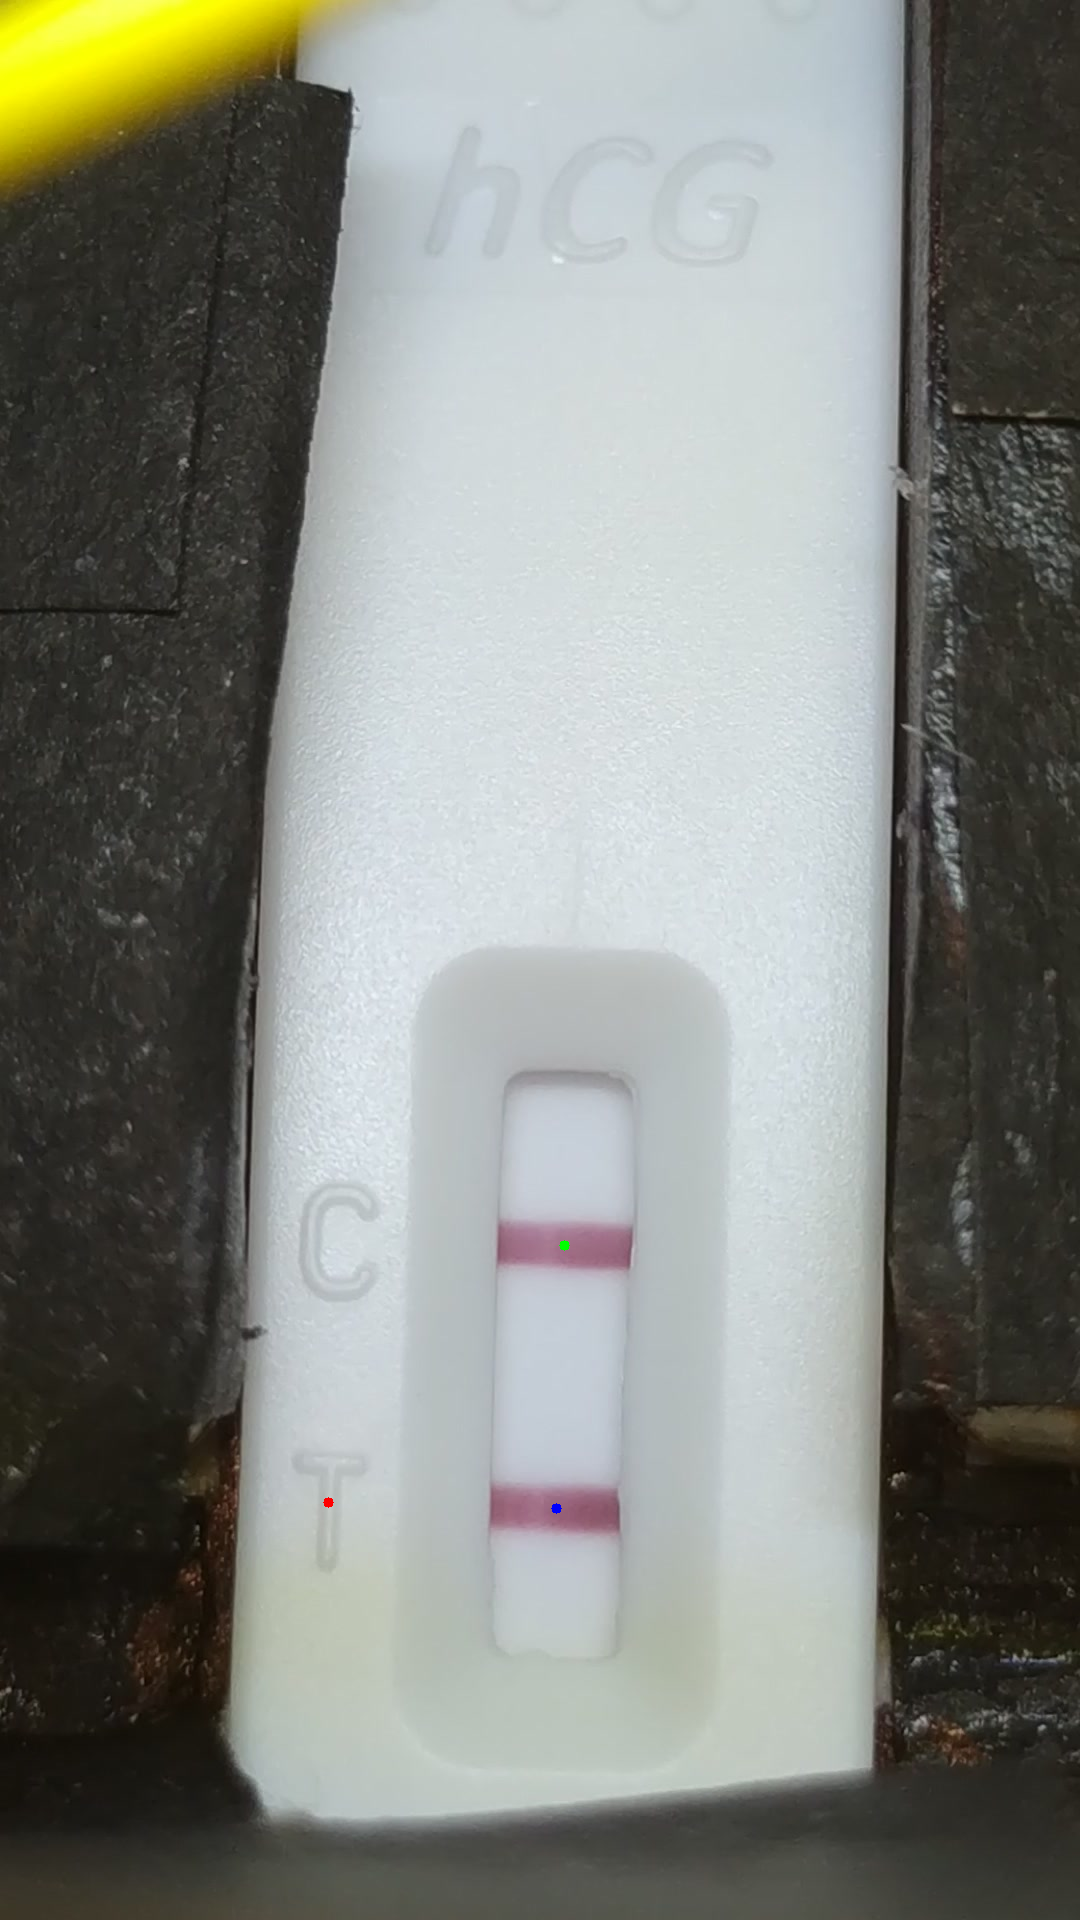

In [45]:
work(paths[4], T_C_ratio)

## shows an increasing trend with increasing concentration

In [46]:
print(T_C_ratio)

[0.4688682031089786, 0.6614168805854503, 0.8079888042885267, 0.9415935766463269, 1.082527360353164]




---



## Next task is to train a model to predict the concentration from intensity of the picture